# This notebook contains the final model used for the web app
* The model uses a Random Forest Classifier

In [38]:
# Modues to be used
import pickle
import json
import csgo
import numpy as np
import pandas as pd
import seaborn as sns
from datetime import datetime

In [3]:
# Load the original data
dict_player, df_map, dict_map = csgo.load_data()

In [4]:
df_map.sort_values(['date'],ascending=False).head()

,map_id,map,date,event_id,event_name,team_id_1,team_name_1,team_score_1,team_kills_1,team_deaths_1,team_assists_1,team_rank_1,team_id_2,team_name_2,team_score_2,team_kills_2,team_deaths_2,team_assists_2,team_rank_2,winner
97594,97594,inf,2020-01-10 01:00:00,5164,Aorus League 2019 #4 Northern Cone,10330,Supremacy,16,99.0,93.0,16.0,420,10578,Infamous,12,93.0,100.0,17.0,420,1
97592,97592,nuke,2020-01-10 01:00:00,5164,Aorus League 2019 #4 Northern Cone,10330,Supremacy,16,98.0,69.0,17.0,420,10578,Infamous,8,69.0,98.0,13.0,420,1
97595,97595,inf,2020-01-10 00:35:00,5104,IEM Katowice 2020 North America Closed Qualifier,5752,Cloud9,16,100.0,91.0,14.0,18,9215,MIBR,12,90.0,100.0,16.0,14,1
97593,97593,ovp,2020-01-10 00:35:00,5104,IEM Katowice 2020 North America Closed Qualifier,5752,Cloud9,16,77.0,46.0,11.0,18,9215,MIBR,4,46.0,77.0,10.0,14,1
97591,97591,trn,2020-01-10 00:35:00,5104,IEM Katowice 2020 North America Closed Qualifier,5752,Cloud9,13,90.0,105.0,12.0,18,9215,MIBR,16,105.0,90.0,20.0,14,2


In [12]:
import importlib
importlib.reload(csgo)

N_MAPS      = 50   # Choose -1 for all
MAX_RANK    = 150
DAYS_WEIGHT = 90
START_DATE  = datetime(2016,6,6)

df_all_feat = csgo.create_pre_train_set( dict_player, df_map, dict_map, DAYS_WEIGHT, MAX_RANK, START_DATE, N_MAPS )

## To save the created dataframe, uncomment the folowing lines 
# filename = 'data_models/all_feat_dataframe_DATE.sav'
# pickle.dump( df_ct_start, open(filename,'wb') )

Total number of matches = 29013
Converting data to DataFrame
Total time to create training set = 0:00:06.197061


## We can also load the previously created training set

In [20]:
f = open('data_models/final_train_df.sav','rb')
df_all_feat = pickle.load(f)

In [24]:
print('Total number of matches = ', len(df_all_feat))

Total number of matches =  29013


In [25]:
df_all_feat.head()

,t1_win,fav_win,fav_ind,map,score_dif,t1_rank,t2_rank,t_0_p_0_prize_rating,t_0_p_1_prize_rating,t_0_p_2_prize_rating,...,t_1_p_0_momentum,t_1_p_1_momentum,t_1_p_2_momentum,t_1_p_3_momentum,t_1_p_4_momentum,t_1_p_0_map_rating,t_1_p_1_map_rating,t_1_p_2_map_rating,t_1_p_3_map_rating,t_1_p_4_map_rating
31497,0,1,2,d2,-8,87,40,0.000000,0.000000,0.000000,...,0.400000,0.333333,0.333333,0.333333,0.333333,3.800000,3.636364,2.750000,2.750000,2.750
31498,1,1,1,ovp,3,40,87,0.617108,0.596164,0.596164,...,0.466667,0.466667,0.466667,0.466667,0.333333,NaN,4.000000,4.000000,4.000000,4.000
31504,0,0,1,d2,-10,43,53,0.692579,0.692579,0.692579,...,0.533333,0.533333,0.533333,0.533333,0.333333,-0.250000,-0.700000,-0.875000,-0.875000,-0.875
31505,1,0,2,mrg,2,53,43,0.639377,0.572519,0.569569,...,0.714286,0.714286,0.714286,0.714286,0.714286,12.500000,12.500000,12.500000,12.500000,12.500
31510,0,1,2,cch,-8,136,36,0.495561,0.495561,0.495561,...,0.666667,0.600000,0.466667,0.466667,0.466667,3.533333,3.533333,3.533333,3.533333,1.000


## Now we do some feature engineering

In [32]:
# First we make sure the data is clean
df_all_feat = df_all_feat.fillna(0)

df_train = df_all_feat[['fav_win','t1_win','fav_ind']].copy()

feat_names = ['prize_rating','rating','hs_perc','kills_per_rd','deaths_per_rd','adr',
                'kast','assists_per_rd','flash_per_rd','first_kills_dif','team_rank',
                'score_dif','win_rate','scaled_win','scaled_rating','scaled_score_dif',
                'win_rate_map','kd_per_round','scaled_kd','momentum','map_rating']

# We also create a dictionary for the normalization that will be used for the web app
dict_normalization = {}
for feat in feat_names:

    avg_0 = 0.0*df_all_feat['t_1_p_0_rating']
    avg_1 = 0.0*df_all_feat['t_1_p_1_rating']

    vec_both = []

    for ind in range(0,5):

        avg_0 = avg_0 + df_all_feat['t_0_p_'+str(ind)+'_'+feat]
        avg_1 = avg_1 + df_all_feat['t_1_p_'+str(ind)+'_'+feat]

        vec_both.append( df_all_feat['t_0_p_'+str(ind)+'_'+feat].values ) 
        vec_both.append( df_all_feat['t_1_p_'+str(ind)+'_'+feat].values ) 
   
    # Normalize and save the normalization values for the web app
    dict_normalization[feat] = {}
    dict_normalization[feat]['mean'] = np.mean(vec_both)
    dict_normalization[feat]['std']  = np.std(vec_both)

    avg_0 = (avg_0 - np.mean(vec_both)) / np.std(vec_both)
    avg_1 = (avg_1 - np.mean(vec_both)) / np.std(vec_both)

    df_train[feat+'_dif'] = ( avg_0 - avg_1 ) / 5


df_train['tier_1'] = np.ceil( df_all_feat['t1_rank'] / 20.0 )
df_train['tier_2'] = np.ceil( df_all_feat['t2_rank'] / 20.0 )

df_train = df_train.fillna(0)

df_train['fav_ind']   = -1.0*(df_train['prize_rating_dif']>=0.0) + 1.0*(df_train['prize_rating_dif']<0.0)
df_train['fav_ind_2'] = -1.0*(df_train['rating_dif']>=0.0) + 1.0*(df_train['rating_dif']<0.0)
df_train['fav_ind_3'] = -1.0*(df_train['kills_per_rd_dif']>=0.0) + 1.0*(df_train['kills_per_rd_dif']<0.0)

print('Mean of CT wins = ',df_train['t1_win'].mean())

df_train.tail(n=80)

Mean of CT wins =  0.5008789163478441


,fav_win,t1_win,fav_ind,prize_rating_dif,rating_dif,hs_perc_dif,kills_per_rd_dif,deaths_per_rd_dif,adr_dif,kast_dif,...,scaled_score_dif_dif,win_rate_map_dif,kd_per_round_dif,scaled_kd_dif,momentum_dif,map_rating_dif,tier_1,tier_2,fav_ind_2,fav_ind_3
97490,0,0,-1.0,0.703403,-0.348008,-0.425264,-0.416823,0.214299,-0.376182,-0.254745,...,-1.124069,-0.126876,-0.541530,-0.874358,-1.353951,-1.084605,2.0,4.0,1.0,1.0
97491,1,0,-1.0,1.343076,2.005799,0.646436,1.535165,1.321096,1.654750,2.972975,...,0.053010,-0.002953,0.504626,0.025537,2.080160,-0.470765,6.0,5.0,-1.0,-1.0
97492,0,0,1.0,-0.255373,0.010410,-0.169967,0.017783,-0.082043,-0.083886,0.005859,...,-0.770420,0.006047,0.074568,-0.689170,-1.846296,-0.973705,2.0,2.0,-1.0,-1.0
97493,1,0,1.0,-0.703403,0.348008,0.425264,0.416823,-0.214299,0.376182,0.254745,...,1.124069,-0.379142,0.541530,0.874358,1.353951,-1.892290,4.0,2.0,-1.0,-1.0
97494,0,1,-1.0,0.255373,-0.010410,0.169967,-0.017783,0.082043,0.083886,-0.005859,...,0.770420,0.101901,-0.074568,0.689170,1.846296,0.354458,2.0,2.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
97582,1,0,1.0,-0.167106,-0.119458,0.013971,-0.007506,0.153676,0.025360,-0.244807,...,0.067229,-3.729163,-0.115517,-0.471349,-1.040080,-0.585793,2.0,1.0,1.0,1.0
97586,1,0,1.0,-0.167106,-0.119458,0.013971,-0.007506,0.153676,0.025360,-0.244807,...,0.067229,-0.723486,-0.115517,-0.471349,-1.040080,0.332305,2.0,1.0,1.0,1.0
97591,1,0,1.0,-0.534889,0.288002,0.219408,0.146491,0.113026,0.237025,0.285987,...,-0.920322,-0.089541,0.057358,-0.920074,-1.120086,0.692301,1.0,1.0,-1.0,-1.0
97593,0,0,-1.0,0.534889,-0.288002,-0.219408,-0.146491,-0.113026,-0.237025,-0.285987,...,0.920322,0.014856,-0.057358,0.920074,1.120086,-0.847025,1.0,1.0,1.0,1.0


### In case we want to save the normalization dictionary

In [ ]:
# # Save the normaliation dictionary for the web app
# filename = 'dict_normalization_DATE.sav'
# pickle.dump( dict_normalization, open(filename,'wb') )

## Now let's look at some descriptive metrics of the data set

In [33]:
df_train.head()

,fav_win,t1_win,fav_ind,prize_rating_dif,rating_dif,hs_perc_dif,kills_per_rd_dif,deaths_per_rd_dif,adr_dif,kast_dif,...,scaled_score_dif_dif,win_rate_map_dif,kd_per_round_dif,scaled_kd_dif,momentum_dif,map_rating_dif,tier_1,tier_2,fav_ind_2,fav_ind_3
31497,1,0,1.0,-2.744813,-0.287202,-0.482375,-0.132118,0.661124,-0.086233,0.082032,...,-0.004961,-0.309352,-0.590422,0.047588,0.560043,2.675808,5.0,2.0,1.0,1.0
31498,1,1,-1.0,2.744813,0.287202,0.482375,0.132118,-0.661124,0.086233,-0.082032,...,0.004961,0.067884,0.590422,-0.047588,-0.560043,-0.609225,2.0,5.0,-1.0,-1.0
31504,0,0,-1.0,1.233932,0.507523,0.055802,0.363711,-0.515563,0.328587,0.142579,...,-0.003264,0.016942,0.704487,-0.096250,1.325817,2.413363,3.0,3.0,-1.0,-1.0
31505,0,1,1.0,-1.233932,-0.507523,-0.055802,-0.363711,0.515563,-0.328587,-0.142579,...,0.003264,-0.156677,-0.704487,0.096250,-1.325817,-2.492285,3.0,3.0,1.0,1.0
31510,1,0,1.0,-1.117700,-0.709331,0.072305,-0.390634,1.461417,0.077261,-0.489566,...,-0.355315,-0.267682,-1.397430,-0.372656,-1.360105,-1.511986,7.0,2.0,1.0,1.0


In [34]:
df_train[['fav_win', 't1_win', 'fav_ind', 'map_rating_dif']].head(n=10)

,fav_win,t1_win,fav_ind,map_rating_dif
31497,1,0,1.0,2.675808
31498,1,1,-1.0,-0.609225
31504,0,0,-1.0,2.413363
31505,0,1,1.0,-2.492285
31510,1,0,1.0,-1.511986
31511,1,1,-1.0,0.542764
31524,1,0,1.0,-0.626941
31528,1,0,1.0,-0.074235
31529,0,0,1.0,0.166152
31530,1,0,1.0,-1.276999


In [44]:
df_train.describe()

,fav_win,t1_win,fav_ind,prize_rating_dif,rating_dif,hs_perc_dif,kills_per_rd_dif,deaths_per_rd_dif,adr_dif,kast_dif,...,scaled_score_dif_dif,win_rate_map_dif,kd_per_round_dif,scaled_kd_dif,momentum_dif,map_rating_dif,tier_1,tier_2,fav_ind_2,fav_ind_3
count,29013.000000,29013.000000,29013.000000,29013.000000,29013.000000,29013.000000,29013.000000,29013.000000,29013.000000,29013.000000,...,29013.000000,29013.000000,29013.000000,29013.000000,29013.000000,29013.000000,29013.000000,29013.000000,29013.000000,29013.000000
mean,0.607452,0.500879,-0.012029,0.012314,0.013460,-0.002862,0.009974,-0.007909,0.009712,0.012838,...,0.011716,-0.028001,0.014921,0.010761,0.002976,-0.102117,2.955916,2.986523,-0.012098,-0.011753
std,0.488326,0.500008,0.999945,0.889136,0.769483,0.518543,0.630627,0.760666,0.612973,0.791830,...,1.279341,1.174288,0.810786,0.937209,1.174507,1.281473,1.819160,1.858701,0.999944,0.999948
min,0.000000,0.000000,-1.000000,-4.577593,-5.910356,-3.382910,-5.960833,-8.465565,-6.526893,-8.496918,...,-15.615358,-23.178578,-5.212296,-8.676804,-4.935765,-7.476855,1.000000,1.000000,-1.000000,-1.000000
25%,0.000000,0.000000,-1.000000,-0.457738,-0.410786,-0.331978,-0.302026,-0.418975,-0.262815,-0.340026,...,-0.281188,-0.204069,-0.498176,-0.208306,-0.800062,-0.889909,1.000000,1.000000,-1.000000,-1.000000
50%,1.000000,1.000000,-1.000000,0.008565,0.010266,-0.003306,0.005993,-0.014601,0.005176,0.006958,...,0.000404,-0.011289,0.016553,0.002296,0.000000,-0.092307,3.000000,3.000000,-1.000000,-1.000000
75%,1.000000,1.000000,1.000000,0.469107,0.433554,0.325947,0.317264,0.404025,0.273618,0.355418,...,0.283309,0.166314,0.526476,0.214379,0.800062,0.684999,4.000000,4.000000,1.000000,1.000000
max,1.000000,1.000000,1.000000,4.362335,5.349599,3.113949,5.071205,5.543184,5.516330,7.061607,...,15.758103,23.706124,4.661788,8.676804,4.935765,6.369173,8.000000,8.000000,1.000000,1.000000


### Let's look at the distribution of all the features

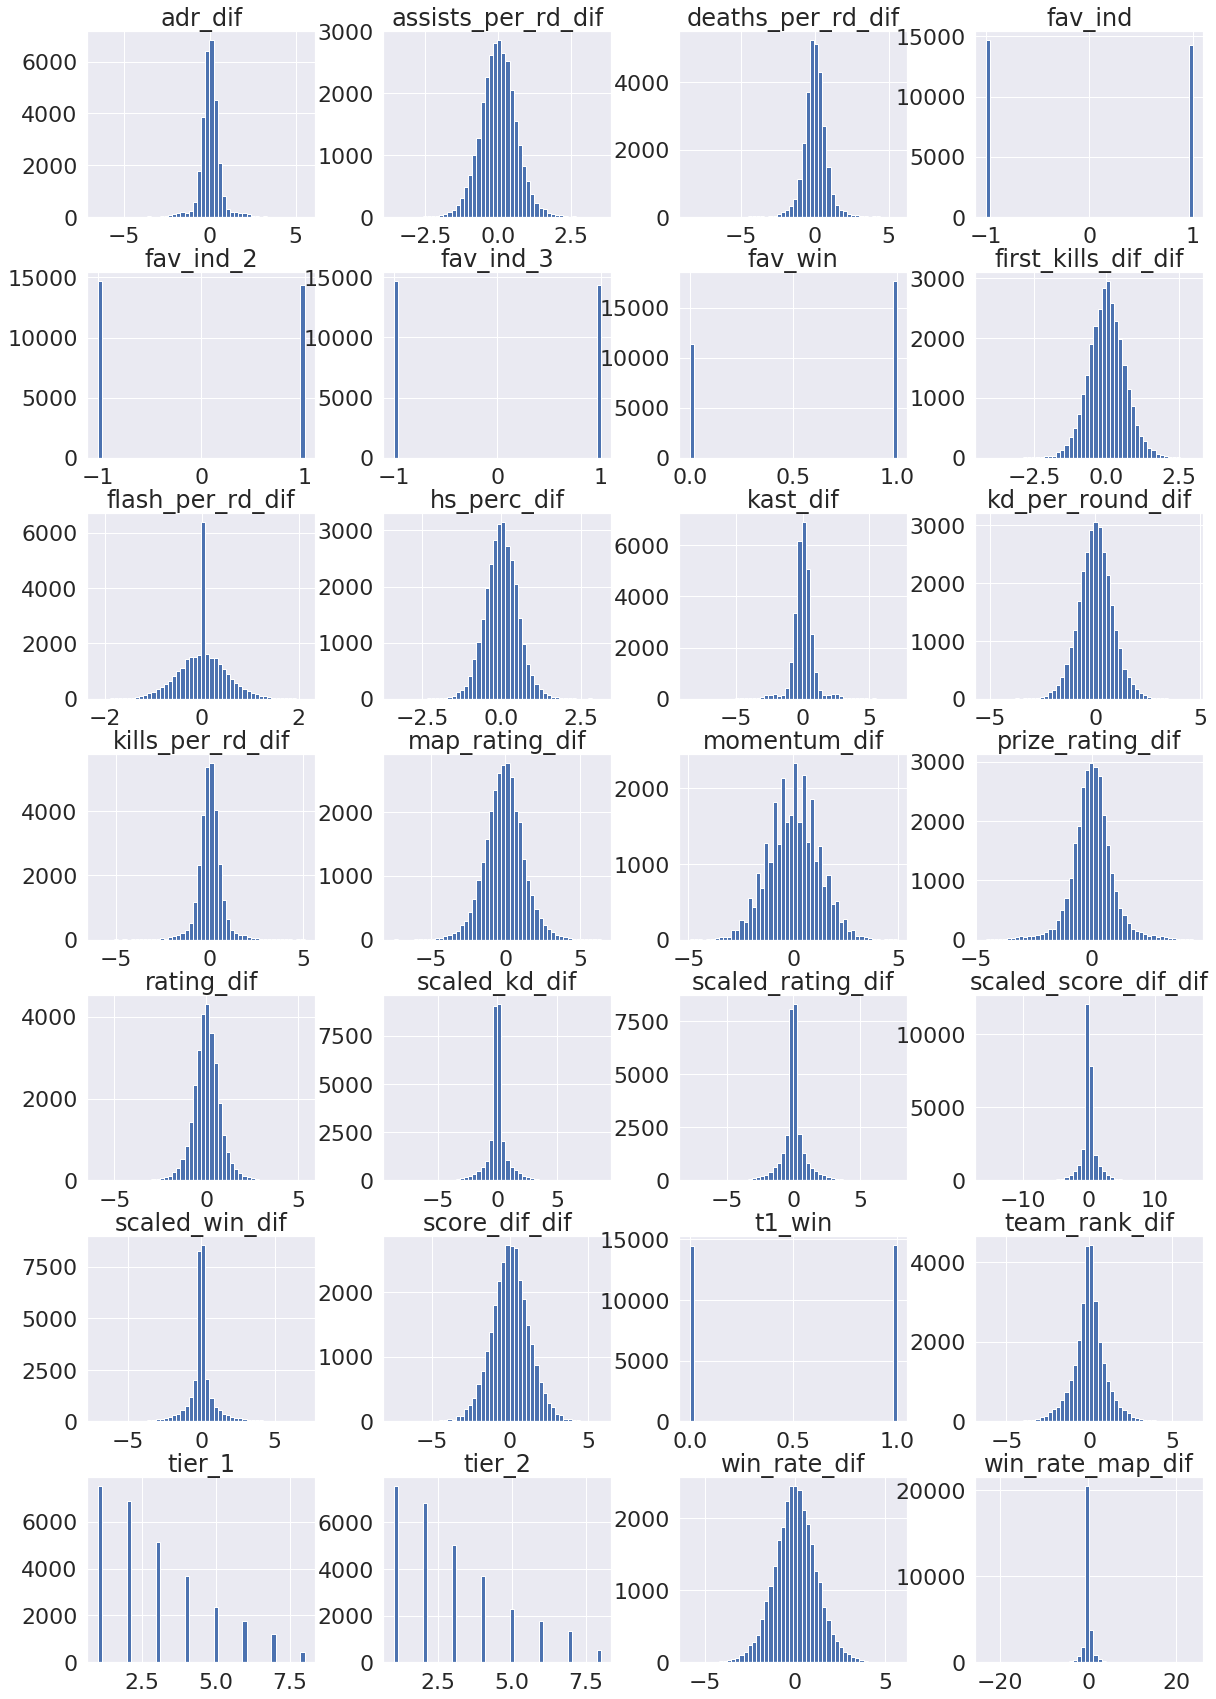

In [43]:
sns.set_style("whitegrid")
sns.set(font_scale=2)

ax = df_train.hist(figsize=(20,30),bins=50,layout=(7,4))

In [174]:
df_train[df_train['t1_win']==1][['prize_rating_dif','scaled_win_dif']].describe()

,prize_rating_dif,scaled_win_dif
count,495.000000,495.000000
mean,0.227814,0.156660
std,0.972410,0.921393
min,-4.294535,-6.860687
25%,-0.252996,-0.037509
50%,0.177084,0.134580
75%,0.584404,0.352129
max,4.114808,4.603757


In [175]:
df_train[df_train['t1_win']==0][['prize_rating_dif','scaled_win_dif']].describe()

,prize_rating_dif,scaled_win_dif
count,505.000000,505.000000
mean,-0.223303,-0.153558
std,0.976928,1.049901
min,-4.294535,-11.281118
25%,-0.638892,-0.259403
50%,-0.178711,0.002556
75%,0.245448,0.183122
max,4.291147,3.242652


In [47]:
correlations = df_train.drop(['fav_win'],axis=1).corr()

%matplotlib qt

sns.set_style("whitegrid")
sns.set(font_scale=1)
plt.figure(figsize=(20,16));
ax = plt.axes()

sns.heatmap(correlations, vmax=1.0, center=0, fmt='.2f',
                square=True, linewidths=.5, annot=True, cbar_kws={"shrink": .70}, ax=ax)

In [337]:
df_ct_start = pd.DataFrame.from_dict( map_training_dict,orient='index')
len( df_ct_start )

# type(data['roundHistory'][0]['ctTeam'])
df_ct_start.tail()

,t1_win,fav_win,fav_ind,map,score_dif,t1_rank,t2_rank,t_0_p_0_prize_rating,t_0_p_1_prize_rating,t_0_p_2_prize_rating,...,t_1_p_0_scaled_rating,t_1_p_1_scaled_rating,t_1_p_2_scaled_rating,t_1_p_3_scaled_rating,t_1_p_4_scaled_rating,t_1_p_0_scaled_score_dif,t_1_p_1_scaled_score_dif,t_1_p_2_scaled_score_dif,t_1_p_3_scaled_score_dif,t_1_p_4_scaled_score_dif
96641,0,1,2,trn,-10,97,41,0.663651,0.629862,0.569225,...,0.043875,0.039537,0.034187,0.032402,0.029116,-0.098653,-0.102610,-0.102610,-0.102906,-0.102906
96639,1,1,1,inf,8,41,97,0.721413,0.709766,0.709069,...,0.097023,0.008072,0.007778,0.007525,0.006096,-0.016848,-0.021450,-0.021450,-0.022641,-0.820086
96638,1,1,1,mrg,8,35,48,0.818040,0.799803,0.799803,...,0.026508,0.022743,0.022248,0.021855,0.019667,-0.024231,-0.024263,-0.024263,-0.025765,-0.033227
96634,0,1,2,trn,-2,48,35,0.726537,0.726537,0.720326,...,0.063923,0.055480,0.054788,0.052385,0.028128,-0.077340,-0.136681,-0.136681,-0.136681,-0.139161
96624,0,1,2,nuke,-3,84,35,0.699892,0.697520,0.697520,...,0.063923,0.055480,0.054788,0.052385,0.028128,-0.077340,-0.136681,-0.136681,-0.136681,-0.139161


In [349]:
df_ct_start.tail(n=20)
print(df_ct_start[df_ct_start['map']=='inf']['t1_win'].mean())
#df_ct_start['t1_rank'].max()
print(df_ct_start['fav_win'].mean())

0.49171270718232046
0.574


In [242]:
df_train[['fav_win','tier_1','tier_2','team_rank_dif']].head(n=30)
# X = df_train.iloc[:, 2:15]
# np.shape(X)

,fav_win,tier_1,tier_2,team_rank_dif
95444,1,6.0,7.0,-0.444945
95448,0,5.0,3.0,0.582442
95451,0,3.0,5.0,-0.336810
95454,1,9.0,12.0,0.041625
95455,1,12.0,9.0,0.209711
95457,0,6.0,3.0,0.158154
95458,0,10.0,9.0,0.949587
95463,0,6.0,3.0,-0.318071
95466,0,9.0,10.0,-0.996637
95488,0,6.0,8.0,-1.530299


In [549]:
df_train.keys().values

array(['fav_win', 't1_win', 'fav_ind', 'prize_rating_dif', 'rating_dif',
       'hs_perc_dif', 'kills_per_rd_dif', 'deaths_per_rd_dif', 'adr_dif',
       'kast_dif', 'assists_per_rd_dif', 'flash_per_rd_dif',
       'first_kills_dif_dif', 'team_rank_dif', 'score_dif_dif',
       'win_rate_dif', 'scaled_win_dif', 'scaled_rating_dif',
       'scaled_score_dif_dif', 'win_rate_map_dif', 'kd_per_round_dif',
       'scaled_kd_dif', 'momentum_dif', 'map_rating_dif', 'tier_1',
       'tier_2', 'fav_ind_2', 'fav_ind_3'], dtype=object)

In [904]:
# Quick XGBoost
from sklearn.model_selection import KFold
from sklearn.preprocessing import MinMaxScaler
import xgboost as xgb
#from sklearn.metrics import cross_validation   #Additional scklearn functions
#from sklearn.model_selection import GridSearchCV   #Perforing grid search

from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
import seaborn as sns

import matplotlib as mpl
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestClassifier
# from sklearn.metrics import plot_roc_curve
from sklearn import metrics

# model = XGBClassifier(
#     learning_rate =0.1,
#     n_estimators=600,
#     max_depth=5,
#     min_child_weight=5,
#     gamma=1,
#     subsample=0.8,
#     colsample_bytree=0.8,
#     objective= 'binary:logistic',
#     nthread=4,
#     scale_pos_weight=1,
#     seed=0)



all_keys = ['fav_ind','prize_rating_dif', 'rating_dif', 'hs_perc_dif',
       'kills_per_rd_dif', 'deaths_per_rd_dif', 'adr_dif', 'kast_dif',
       'assists_per_rd_dif', 'flash_per_rd_dif', 'first_kills_dif_dif',
       'team_rank_dif', 'score_dif_dif', 'win_rate_dif',
       'scaled_win_dif','scaled_rating_dif','scaled_score_dif']

features = ['t1_win','tier_1','tier_2','fav_ind','fav_ind_2','fav_ind_3','prize_rating_dif', 'rating_dif', 'deaths_per_rd_dif', 
       'assists_per_rd_dif', 'flash_per_rd_dif', 'first_kills_dif_dif',
       'score_dif_dif', 'win_rate_dif','scaled_win_dif',
       'scaled_rating_dif','scaled_score_dif_dif','win_rate_map_dif']


features = ['t1_win', 'fav_ind', 'prize_rating_dif', 'rating_dif',
       'hs_perc_dif', 'kills_per_rd_dif', 'deaths_per_rd_dif', 'adr_dif',
       'kast_dif', 'assists_per_rd_dif', 'flash_per_rd_dif',
       'first_kills_dif_dif', 'team_rank_dif', 'score_dif_dif',
       'win_rate_dif', 'scaled_win_dif', 'scaled_rating_dif',
       'scaled_score_dif_dif', 'win_rate_map_dif', 'kd_per_round_dif',
       'scaled_kd_dif', 'tier_1', 'tier_2', 'fav_ind_2', 'fav_ind_3','momentum_dif','map_rating_dif']

# These features are giving 63%
features = ['t1_win', 'prize_rating_dif',  'score_dif_dif', 
        'win_rate_dif', 'scaled_win_dif', 'scaled_rating_dif','win_rate_map_dif', 'kd_per_round_dif',
        'momentum_dif']

labels = ['Team 1 win', '$\Delta$ Prize Rating', '$\Delta$ Score', '$\Delta$ Win %', '$\Delta$ Scaled Win',
        '$\Delta$ Scaled Rating', '$\Delta$ Win % Map', '$\Delta$ KD per Round', '$\Delta$ Momentum']



# features = ['t1_win', 'fav_ind', 'prize_rating_dif', 'rating_dif',
#        'hs_perc_dif', 'kills_per_rd_dif', 'deaths_per_rd_dif', 'adr_dif',
#        'kast_dif', 'assists_per_rd_dif', 'flash_per_rd_dif',
#        'first_kills_dif_dif', 'team_rank_dif', 'score_dif_dif',
#        'win_rate_dif', 'scaled_win_dif', 'scaled_rating_dif',
#        'scaled_score_dif_dif', 'win_rate_map_dif', 'kd_per_round_dif',
#        'scaled_kd_dif', 'momentum_dif', 'map_rating_dif', 'tier_1',
#        'tier_2', 'fav_ind_2', 'fav_ind_3']


# features = ['t1_win','fav_ind','fav_ind_2']

# features = ['t1_win','win_rate_dif','team_rank_dif']

# df_tmp = df_train[ features ].head(n=10000).copy()

df_tmp = df_train[ features ].copy()

# Get rid of outliers
# df_tmp = df_tmp[ np.abs(df_tmp['win_rate_map_dif'])<3.0  ]
df_tmp = df_tmp[ np.abs(df_tmp['scaled_rating_dif'])<3.0  ]
# df_tmp = df_tmp[ np.abs(df_tmp['adr_dif'])<3.0  ]
# df_tmp = df_tmp[ np.abs(df_tmp['assists_per_rd_dif'])<3.0  ]
# df_tmp = df_tmp[ np.abs(df_tmp['deaths_per_rd_dif'])<3.0  ]
df_tmp = df_tmp[ np.abs(df_tmp['kd_per_round_dif'])<3.0  ]
# df_tmp = df_tmp[ np.abs(df_tmp['map_rating_dif'])<3.0  ]
df_tmp = df_tmp[ np.abs(df_tmp['scaled_win_dif'])<3.0  ]
# df_tmp = df_tmp[ np.abs(df_tmp['scaled_score_dif_dif'])<3.0  ]


# df_tmp = df_tmp[ np.abs(df_tmp['team_rank_dif'])<1.5]

n = len(df_tmp.keys())
X = df_tmp.iloc[:, 1:n].values
y = df_tmp.iloc[:, 0].values

# Scale all variables to [0,1]
# scaler = MinMaxScaler(feature_range=(0, 1))
# X = scaler.fit_transform(X)


cv = KFold(n_splits=2, random_state=None, shuffle=True)


model = XGBClassifier(
        learning_rate=0.01,
        n_estimators=500,
        max_depth=3,
        min_child_weight=1,
        gamma=10,
        subsample=0.8,
        colsample_bytree=0.6,
        objective= 'binary:logistic',
        nthread=4,
        scale_pos_weight=1 )

clf = RandomForestClassifier(n_estimators=200,max_depth=3, random_state=1, bootstrap=False,n_jobs=6)


accuracy_vec = []

for train_index, test_index in cv.split(X):
#for test_index, train_index in cv.split(X):
    # print("Train Index: ", train_index, "\n")
    # print("Test Index: ", test_index)

    X_train, X_test, y_train, y_test = X[train_index,:], X[test_index,:], y[train_index], y[test_index]
    # best_svr.fit(X_train, y_train)
    # scores.append(best_svr.score(X_test, y_test))
    
#     model.fit(X_train,y_train) 
#     y_pred = model.predict(X_test)
#     y_train_pred = model.predict(X_train)
#     y_train_proba = model.predict_proba(X_train)[:,1]

    
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    y_train_pred = clf.predict(X_train)
    y_train_proba = clf.predict_proba(X_train)[:,1]

    predictions = [round(value) for value in y_pred]
    

    print('--------------------------------------------------------------')
    print('XGBoost')
    print('')
    print('Accuracy (Train): %.4g' % accuracy_score(y_train, y_train_pred) )
    print('AUC Score (Train): %f' % roc_auc_score(y_train, y_train_proba) )
    print('')
    print('>'+classification_report(y_test,predictions,target_names=['T Start','CT Start']))

    print('Accuracy (Test): %.4g' % accuracy_score(y_test, y_pred) )
    print('AUC Score (Test): %f' % roc_auc_score(y_test, y_pred) )

    accuracy_vec.append( accuracy_score(y_test, y_pred) )


print('--------------------------------------------------------------')
print('Avg accuracy (Test) = %f' % np.mean(accuracy_vec) )
print('--------------------------------------------------------------')

sns.set_style("whitegrid")
sns.set(font_scale=5)

plt.figure(figsize=(20,18));



mpl.rcParams.update({'text.color' : "white",
                     'axes.labelcolor' : "white",
                     'xtick.color' : "white",
                     'ytick.color' : "white"})

ax = plt.axes()

fpr, tpr, thresholds = metrics.roc_curve(y_test, clf.predict_proba(X_test)[:,1] )  # doctest: +SKIP

ax.plot( fpr, tpr, lw=10, color='g',
        label='AUC = %.2f' % (roc_auc_score(y_test, y_pred)), alpha=.8 )
ax.plot([0, 1], [0, 1], linestyle='--', lw=10, color='r',
        label='Chance', alpha=.8 )

plt.legend()
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

plt.savefig('ROC_feb9.png', transparent=True, bbox_inches="tight")
plt.show()



--------------------------------------------------------------
XGBoost

Accuracy (Train): 0.6373
AUC Score (Train): 0.681221

>              precision    recall  f1-score   support

     T Start       0.61      0.62      0.62      6985
    CT Start       0.62      0.61      0.61      7007

   micro avg       0.62      0.62      0.62     13992
   macro avg       0.62      0.62      0.62     13992
weighted avg       0.62      0.62      0.62     13992

Accuracy (Test): 0.6156
AUC Score (Test): 0.615642
--------------------------------------------------------------
XGBoost

Accuracy (Train): 0.6262
AUC Score (Train): 0.674829

>              precision    recall  f1-score   support

     T Start       0.64      0.61      0.62      7028
    CT Start       0.62      0.65      0.64      6964

   micro avg       0.63      0.63      0.63     13992
   macro avg       0.63      0.63      0.63     13992
weighted avg       0.63      0.63      0.63     13992

Accuracy (Test): 0.6306
AUC Score (Test):

In [905]:
# filename = 'final_model_rand_forest_feb_9_2020.sav'
# pickle.dump( clf, open(filename,'wb') )

In [864]:
# std = np.std([tree.feature_importances_ for tree in clf.estimators_],
#              axis=0)

order = np.argsort( clf.feature_importances_ )[::-1][:n]
feat_new = [labels[order[ind]+1] for ind in range(0,n-1)]

# df = pd.DataFrame( {'importance':np.array(clf.feature_importances_[order]), 
#     'features':feat_new, 'std':std[order]} )


dic_aux = {}
dic_aux['Feature'] = []
dic_aux['Importance'] = []
count = -1
for tree in clf.estimators_:
    count = count+1
    
    for ind in range(0,n-1):
        dic_aux['Feature'].append( labels[ind+1] )
        dic_aux['Importance'].append( tree.feature_importances_[ind] )

df = pd.DataFrame.from_dict(dic_aux,orient="columns")

sns.set_style("whitegrid")
sns.set(font_scale=4)


mpl.rcParams.update({'text.color' : "white",
                     'axes.labelcolor' : "white",
                     'xtick.color' : "white",
                     'ytick.color' : "white"})


plt.figure(figsize=(12*1.5,8*1.5));
ax = plt.axes()
ax = sns.barplot(x="Importance", y="Feature", data=df, order=feat_new, capsize=0.2 )

# plt.savefig('importance_feb9.png', transparent=True, bbox_inches="tight")


In [898]:
%matplotlib qt
sns.set_style("whitegrid")
sns.set(font_scale=2)

plt.figure(figsize=(20,20))
ax = plt.axes()
df_tmp.hist(ax=ax,bins=40)
plt.tight_layout()

plt.show()
print(df_tmp['win_rate_map_dif'].min())

/home/emmanuel/miniconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3296: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  exec(code_obj, self.user_global_ns, self.user_ns)
-2.9953354787687565


In [6]:
correlations = df_tmp.drop(['t1_win'],axis=1).corr()

%matplotlib qt

sns.set_style("whitegrid")
sns.set(font_scale=2.5)
plt.figure(figsize=(15,15));

mpl.rcParams.update({'text.color' : "white",
                     'axes.labelcolor' : "white",
                     'xtick.color' : "white",
                     'ytick.color' : "white"})
ax = plt.axes()

sns.heatmap(correlations, vmax=1.0, center=0, fmt='.2f',
                square=True, linewidths=.5, annot=True, cbar_kws={"shrink": .70}, ax=ax,
                xticklabels=labels[1:n],
                yticklabels=labels[1:n])
plt.tight_layout()

plt.show()

# plt.savefig('correlations_feb9.png', transparent=True, bbox_inches="tight")


NameError: name 'df_tmp' is not defined